# Modelling Genre

Author-Topic Modelling -> Genre-Topic Modelling

https://nbviewer.jupyter.org/github/rare-technologies/gensim/blob/develop/docs/notebooks/atmodel_tutorial.ipynb

## Latent Dirichlet Allocation

### Training a topic model on the Books corpus

In [52]:
import glob
import random
RND = 12345
random.seed(RND)
from nltk.tokenize import word_tokenize

def chunker(l, n):
    """Yield successive n-sized chunks from l."""
    l = ''.join([c for c in l if c.isalpha() or c.isspace()])
    l = word_tokenize(l)
    l = [t.lower() for t in l]
    for i in range(0, len(l), n):
        yield l[i:i + n]        

class ParagraphIterator(object):
    def __init__(self, path, max_per_book=None,
                 chunk_size=300, max_books=None,
                 convert=False, vocab=None):
        self.max_books = max_books
        self.max_per_book = max_per_book
        self.chunk_size = chunk_size
        self.doc2genre = {}
        self.genre2doc = {}
        self.convert = convert
        if self.convert:
            self.vocab = vocab
        self.filenames = sorted(list(glob.glob(path)))
        random.seed(RND)
        random.shuffle(self.filenames)
        if self.max_books:
            self.filenames = self.filenames[:self.max_books]
        
        self.book2genre = {}
        for filename in self.filenames:
            comps = filename.split('/')
            genre, title = comps[-2:]
            try:
                self.book2genre[title].append(genre)
            except KeyError:
                self.book2genre[title] = [genre]

    def __iter__(self):
        for filename in self.filenames:
            comps = filename.split('/')
            _, title = comps[-2:]
            genres = self.book2genre[title]
            with open(filename, 'r') as f:
                try:
                    if self.max_per_book:
                        text = f.read(self.max_per_book)
                    else:
                        text = f.read()
                except:
                    continue
            for ch in chunker(text, self.chunk_size):
                if ch:
                    idx = len(self.doc2genre)
                    self.doc2genre[idx] = genres
                    for genre in genres:
                        try:
                            self.genre2doc[genre].append(idx)
                        except KeyError:
                            self.genre2doc[genre] = [idx]
                    if self.convert:
                        yield self.vocab.doc2bow(ch)
                    else:
                        yield ch

Set hyperparams:

In [53]:
path = '/Users/mike/GitRepos/potter/data/other/books_txt_full/*/*.txt'
n_features = 3000
n_topics = 50
n_top_words = 60
max_freq = 0.5
min_wordcount = 20
max_books = 1000
cut_top = 500
max_per_book = 100000

Inspect genre overlap:

In [54]:
paragraphs = ParagraphIterator(path, max_books=None, convert=False, max_per_book=max_per_book)
from collections import Counter
mults = Counter([len(genres) for title, genres in paragraphs.book2genre.items()])
mults

Counter({1: 4257, 2: 2101, 3: 741, 4: 82, 5: 6})

How often do books have multiple genres?

Text(0.5,1,'Distribution of genres over books')

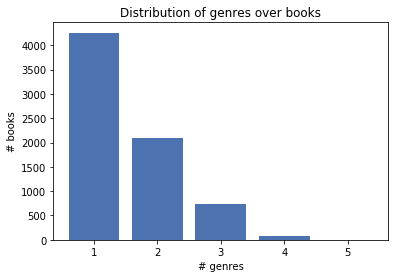

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
x, heights = list(zip(*mults.items()))
plt.bar(x=x, height=heights)
plt.xlabel('# genres')
plt.ylabel('# books')
plt.title('Distribution of genres over books')

How do genre labels cooccur?

['Adventure', 'Fantasy', 'Historical', 'Horror', 'Humor', 'Literature', 'Mystery', 'New_Adult', 'Other', 'Romance', 'Science_fiction', 'Teen', 'Themes', 'Thriller', 'Vampires', 'Young_Adult']


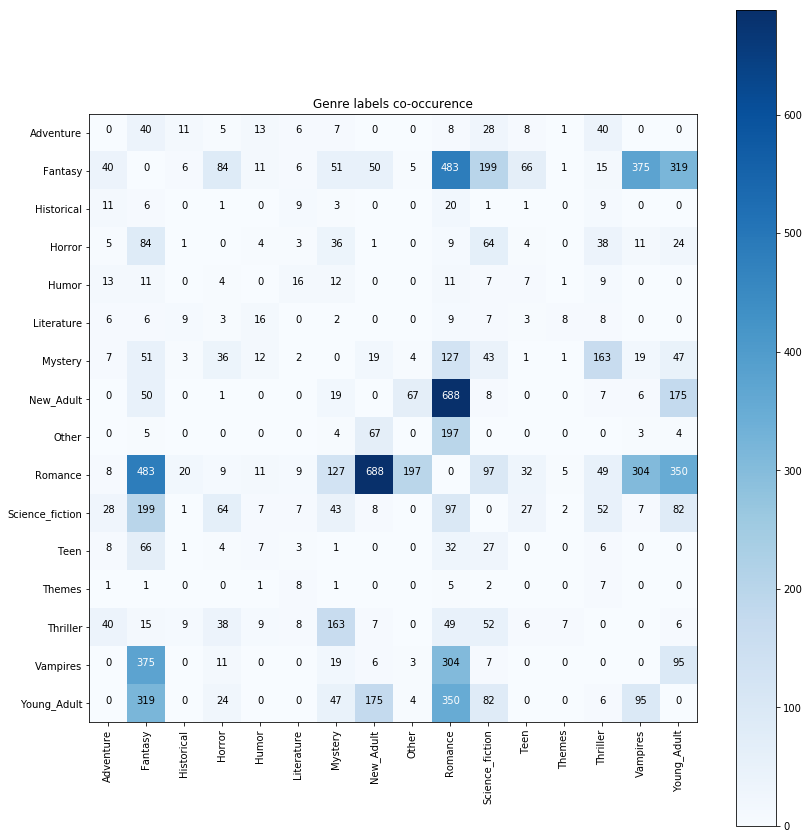

In [56]:
from itertools import combinations
import numpy as np
from itertools import product

G = sorted(set([label for labels in paragraphs.book2genre.values() for label in labels]))
C = np.zeros((len(G), len(G)), dtype=np.int64)
print(G)

for _, genres in paragraphs.book2genre.items():
    for a, b in combinations(genres, 2):
        C[G.index(a), G.index(b)] += 1
        C[G.index(b), G.index(a)] += 1

plt.figure(figsize=(12, 12))
ax = plt.imshow(C, interpolation='nearest', cmap=plt.cm.Blues)
plt.gca().grid(False)
plt.title('Genre labels co-occurence')
plt.colorbar()
tick_marks = np.arange(len(G))
plt.xticks(tick_marks, G, rotation=90)
plt.yticks(tick_marks, G)

thresh = C.max() / 2.
for i, j in product(range(C.shape[0]), range(C.shape[1])):
    plt.text(j, i, format(C[i, j], 'd'),
             horizontalalignment="center",
             color="white" if C[i, j] > thresh else "black")

plt.tight_layout()

How common is each genre?

Text(0.5,1,'Distribution of genres over books')

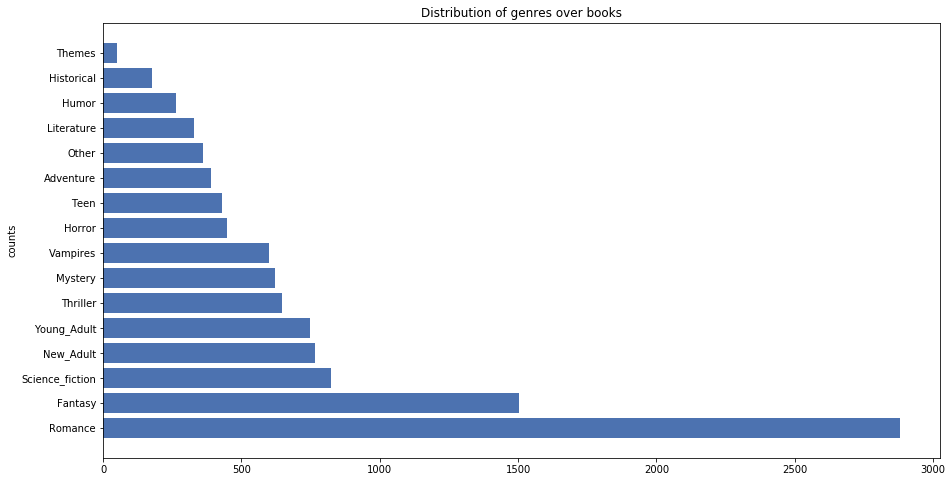

In [57]:
from operator import itemgetter
plt.figure(figsize=(15, 8))
G = Counter([label for labels in paragraphs.book2genre.values() for label in labels])
labels, heights = list(zip(*sorted(list(G.items()), key=itemgetter(1), reverse=True)))
plt.barh(y=range(len(heights)), width=heights)
plt.yticks(range(len(labels)), labels)
plt.ylabel('counts')
plt.title('Distribution of genres over books')

In [58]:
import gensim
from gensim import corpora
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [59]:
paragraphs = ParagraphIterator(path, max_books=1000, convert=False) # devel cut off
dictionary = corpora.Dictionary(paragraphs)
dictionary.filter_extremes(no_below=min_wordcount,
                           no_above=max_freq,
                           keep_n=n_features)
dictionary.filter_n_most_frequent(cut_top)
doc2genre = paragraphs.doc2genre
genre2doc = paragraphs.genre2doc

2018-02-03 20:20:34,411 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-02-03 20:20:49,172 : INFO : adding document #10000 to Dictionary(51317 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-03 20:21:03,782 : INFO : adding document #20000 to Dictionary(73895 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-03 20:21:18,649 : INFO : adding document #30000 to Dictionary(87578 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-03 20:21:34,183 : INFO : adding document #40000 to Dictionary(99682 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-03 20:21:49,462 : INFO : adding document #50000 to Dictionary(119048 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-03 20:22:04,397 : INFO : adding document #60000 to Dictionary(128870 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-03 20:22:19,125 : INFO : adding documen

In [37]:
print(len(doc2genre))
print(len(genre2doc))
#print(len(bow))

229534
16


In [48]:
paragraphs = ParagraphIterator(path, max_books=1000, convert=True, vocab=dictionary)
lda = gensim.models.ldamodel.LdaModel(corpus=paragraphs,
                                      id2word=dictionary,
                                      num_topics=n_topics,
                                      update_every=0,
                                      chunksize=2000,
                                      passes=30,
                                      random_state=RND)

2018-02-03 17:21:25,668 : INFO : using symmetric alpha at 0.02
2018-02-03 17:21:25,669 : INFO : using symmetric eta at 0.0004
2018-02-03 17:21:25,670 : INFO : using serial LDA version on this node
2018-02-03 17:21:26,422 : WARNING : input corpus stream has no len(); counting documents
2018-02-03 17:26:22,612 : INFO : running batch LDA training, 50 topics, 30 passes over the supplied corpus of 229534 documents, updating model once every 229534 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-02-03 17:26:25,237 : INFO : PROGRESS: pass 0, at document #2000/229534
2018-02-03 17:26:33,516 : INFO : PROGRESS: pass 0, at document #4000/229534
2018-02-03 17:26:42,215 : INFO : PROGRESS: pass 0, at document #6000/229534
2018-02-03 17:26:49,532 : INFO : PROGRESS: pass 0, at document #8000/229534
2018-02-03 17:26:57,571 : INFO : PROGRESS: pass 0, at document #10000/229534
2018-02-03 17:27:05,444 : INFO : PROGRESS: pass 0, at documen

2018-02-03 17:39:04,388 : INFO : PROGRESS: pass 0, at document #170000/229534
2018-02-03 17:39:12,869 : INFO : PROGRESS: pass 0, at document #172000/229534
2018-02-03 17:39:21,147 : INFO : PROGRESS: pass 0, at document #174000/229534
2018-02-03 17:39:29,549 : INFO : PROGRESS: pass 0, at document #176000/229534
2018-02-03 17:39:37,607 : INFO : PROGRESS: pass 0, at document #178000/229534
2018-02-03 17:39:55,680 : INFO : -8.649 per-word bound, 401.5 perplexity estimate based on a held-out corpus of 2000 documents with 90113 words
2018-02-03 17:39:55,681 : INFO : PROGRESS: pass 0, at document #180000/229534
2018-02-03 17:40:03,835 : INFO : PROGRESS: pass 0, at document #182000/229534
2018-02-03 17:40:11,833 : INFO : PROGRESS: pass 0, at document #184000/229534
2018-02-03 17:40:19,988 : INFO : PROGRESS: pass 0, at document #186000/229534
2018-02-03 17:40:28,238 : INFO : PROGRESS: pass 0, at document #188000/229534
2018-02-03 17:40:36,668 : INFO : PROGRESS: pass 0, at document #190000/22953

2018-02-03 17:50:15,283 : INFO : PROGRESS: pass 1, at document #94000/229534
2018-02-03 17:50:22,794 : INFO : PROGRESS: pass 1, at document #96000/229534
2018-02-03 17:50:30,208 : INFO : PROGRESS: pass 1, at document #98000/229534
2018-02-03 17:50:45,901 : INFO : -7.859 per-word bound, 232.1 perplexity estimate based on a held-out corpus of 2000 documents with 89049 words
2018-02-03 17:50:45,902 : INFO : PROGRESS: pass 1, at document #100000/229534
2018-02-03 17:50:53,537 : INFO : PROGRESS: pass 1, at document #102000/229534
2018-02-03 17:51:00,871 : INFO : PROGRESS: pass 1, at document #104000/229534
2018-02-03 17:51:08,805 : INFO : PROGRESS: pass 1, at document #106000/229534
2018-02-03 17:51:17,502 : INFO : PROGRESS: pass 1, at document #108000/229534
2018-02-03 17:51:24,809 : INFO : PROGRESS: pass 1, at document #110000/229534
2018-02-03 17:51:32,054 : INFO : PROGRESS: pass 1, at document #112000/229534
2018-02-03 17:51:40,193 : INFO : PROGRESS: pass 1, at document #114000/229534
2

2018-02-03 18:00:56,122 : INFO : PROGRESS: pass 2, at document #16000/229534
2018-02-03 18:01:03,392 : INFO : PROGRESS: pass 2, at document #18000/229534
2018-02-03 18:01:19,572 : INFO : -7.843 per-word bound, 229.6 perplexity estimate based on a held-out corpus of 2000 documents with 92502 words
2018-02-03 18:01:19,573 : INFO : PROGRESS: pass 2, at document #20000/229534
2018-02-03 18:01:27,453 : INFO : PROGRESS: pass 2, at document #22000/229534
2018-02-03 18:01:34,781 : INFO : PROGRESS: pass 2, at document #24000/229534
2018-02-03 18:01:42,349 : INFO : PROGRESS: pass 2, at document #26000/229534
2018-02-03 18:01:49,927 : INFO : PROGRESS: pass 2, at document #28000/229534
2018-02-03 18:01:57,604 : INFO : PROGRESS: pass 2, at document #30000/229534
2018-02-03 18:02:05,259 : INFO : PROGRESS: pass 2, at document #32000/229534
2018-02-03 18:02:12,842 : INFO : PROGRESS: pass 2, at document #34000/229534
2018-02-03 18:02:20,314 : INFO : PROGRESS: pass 2, at document #36000/229534
2018-02-0

2018-02-03 18:13:34,581 : INFO : PROGRESS: pass 2, at document #194000/229534
2018-02-03 18:13:43,453 : INFO : PROGRESS: pass 2, at document #196000/229534
2018-02-03 18:13:51,117 : INFO : PROGRESS: pass 2, at document #198000/229534
2018-02-03 18:14:08,382 : INFO : -7.828 per-word bound, 227.2 perplexity estimate based on a held-out corpus of 2000 documents with 94561 words
2018-02-03 18:14:08,384 : INFO : PROGRESS: pass 2, at document #200000/229534
2018-02-03 18:14:16,592 : INFO : PROGRESS: pass 2, at document #202000/229534
2018-02-03 18:14:25,042 : INFO : PROGRESS: pass 2, at document #204000/229534
2018-02-03 18:14:33,296 : INFO : PROGRESS: pass 2, at document #206000/229534
2018-02-03 18:14:41,421 : INFO : PROGRESS: pass 2, at document #208000/229534
2018-02-03 18:14:49,747 : INFO : PROGRESS: pass 2, at document #210000/229534
2018-02-03 18:14:57,914 : INFO : PROGRESS: pass 2, at document #212000/229534
2018-02-03 18:15:06,270 : INFO : PROGRESS: pass 2, at document #214000/22953

2018-02-03 18:25:02,298 : INFO : PROGRESS: pass 3, at document #118000/229534
2018-02-03 18:25:18,689 : INFO : -7.850 per-word bound, 230.7 perplexity estimate based on a held-out corpus of 2000 documents with 88934 words
2018-02-03 18:25:18,690 : INFO : PROGRESS: pass 3, at document #120000/229534
2018-02-03 18:25:26,863 : INFO : PROGRESS: pass 3, at document #122000/229534
2018-02-03 18:25:35,084 : INFO : PROGRESS: pass 3, at document #124000/229534
2018-02-03 18:25:43,059 : INFO : PROGRESS: pass 3, at document #126000/229534
2018-02-03 18:25:51,647 : INFO : PROGRESS: pass 3, at document #128000/229534
2018-02-03 18:25:59,257 : INFO : PROGRESS: pass 3, at document #130000/229534
2018-02-03 18:26:07,594 : INFO : PROGRESS: pass 3, at document #132000/229534
2018-02-03 18:26:16,104 : INFO : PROGRESS: pass 3, at document #134000/229534
2018-02-03 18:26:23,811 : INFO : PROGRESS: pass 3, at document #136000/229534
2018-02-03 18:26:31,895 : INFO : PROGRESS: pass 3, at document #138000/22953

2018-02-03 18:36:23,416 : INFO : PROGRESS: pass 4, at document #40000/229534
2018-02-03 18:36:31,002 : INFO : PROGRESS: pass 4, at document #42000/229534
2018-02-03 18:36:38,510 : INFO : PROGRESS: pass 4, at document #44000/229534
2018-02-03 18:36:46,391 : INFO : PROGRESS: pass 4, at document #46000/229534
2018-02-03 18:36:54,758 : INFO : PROGRESS: pass 4, at document #48000/229534
2018-02-03 18:37:02,119 : INFO : PROGRESS: pass 4, at document #50000/229534
2018-02-03 18:37:10,008 : INFO : PROGRESS: pass 4, at document #52000/229534
2018-02-03 18:37:17,304 : INFO : PROGRESS: pass 4, at document #54000/229534
2018-02-03 18:37:25,152 : INFO : PROGRESS: pass 4, at document #56000/229534
2018-02-03 18:37:32,731 : INFO : PROGRESS: pass 4, at document #58000/229534
2018-02-03 18:37:48,999 : INFO : -7.801 per-word bound, 223.1 perplexity estimate based on a held-out corpus of 2000 documents with 89038 words
2018-02-03 18:37:49,000 : INFO : PROGRESS: pass 4, at document #60000/229534
2018-02-0

2018-02-03 18:49:25,794 : INFO : PROGRESS: pass 4, at document #220000/229534
2018-02-03 18:49:34,008 : INFO : PROGRESS: pass 4, at document #222000/229534
2018-02-03 18:49:41,268 : INFO : PROGRESS: pass 4, at document #224000/229534
2018-02-03 18:49:49,082 : INFO : PROGRESS: pass 4, at document #226000/229534
2018-02-03 18:49:57,083 : INFO : PROGRESS: pass 4, at document #228000/229534
2018-02-03 18:50:10,708 : INFO : -7.774 per-word bound, 218.8 perplexity estimate based on a held-out corpus of 1534 documents with 69860 words
2018-02-03 18:50:10,709 : INFO : PROGRESS: pass 4, at document #229534/229534
2018-02-03 18:50:14,533 : INFO : topic #0 (0.020): 0.005*"office" + 0.004*"city" + 0.003*"mr" + 0.003*"nose" + 0.003*"business" + 0.003*"desk" + 0.003*"job" + 0.002*"brother" + 0.002*"finger" + 0.002*"major"
2018-02-03 18:50:14,534 : INFO : topic #20 (0.020): 0.007*"james" + 0.003*"girls" + 0.003*"eric" + 0.003*"guys" + 0.002*"telling" + 0.002*"kitchen" + 0.002*"tree" + 0.002*"mr" + 0.

2018-02-03 19:00:22,159 : INFO : PROGRESS: pass 5, at document #144000/229534
2018-02-03 19:00:29,581 : INFO : PROGRESS: pass 5, at document #146000/229534
2018-02-03 19:00:37,434 : INFO : PROGRESS: pass 5, at document #148000/229534
2018-02-03 19:00:45,262 : INFO : PROGRESS: pass 5, at document #150000/229534
2018-02-03 19:00:52,905 : INFO : PROGRESS: pass 5, at document #152000/229534
2018-02-03 19:01:00,424 : INFO : PROGRESS: pass 5, at document #154000/229534
2018-02-03 19:01:08,399 : INFO : PROGRESS: pass 5, at document #156000/229534
2018-02-03 19:01:15,703 : INFO : PROGRESS: pass 5, at document #158000/229534
2018-02-03 19:01:31,240 : INFO : -7.741 per-word bound, 213.9 perplexity estimate based on a held-out corpus of 2000 documents with 88933 words
2018-02-03 19:01:31,241 : INFO : PROGRESS: pass 5, at document #160000/229534
2018-02-03 19:01:38,766 : INFO : PROGRESS: pass 5, at document #162000/229534
2018-02-03 19:01:47,877 : INFO : PROGRESS: pass 5, at document #164000/22953

2018-02-03 19:11:03,732 : INFO : PROGRESS: pass 6, at document #68000/229534
2018-02-03 19:11:11,364 : INFO : PROGRESS: pass 6, at document #70000/229534
2018-02-03 19:11:19,340 : INFO : PROGRESS: pass 6, at document #72000/229534
2018-02-03 19:11:26,813 : INFO : PROGRESS: pass 6, at document #74000/229534
2018-02-03 19:11:35,109 : INFO : PROGRESS: pass 6, at document #76000/229534
2018-02-03 19:11:42,187 : INFO : PROGRESS: pass 6, at document #78000/229534
2018-02-03 19:11:58,021 : INFO : -7.688 per-word bound, 206.3 perplexity estimate based on a held-out corpus of 2000 documents with 90434 words
2018-02-03 19:11:58,022 : INFO : PROGRESS: pass 6, at document #80000/229534
2018-02-03 19:12:05,515 : INFO : PROGRESS: pass 6, at document #82000/229534
2018-02-03 19:12:12,908 : INFO : PROGRESS: pass 6, at document #84000/229534
2018-02-03 19:12:20,492 : INFO : PROGRESS: pass 6, at document #86000/229534
2018-02-03 19:12:28,433 : INFO : PROGRESS: pass 6, at document #88000/229534
2018-02-0

2018-02-03 19:22:34,191 : INFO : topic #29 (0.020): 0.006*"sister" + 0.005*"michael" + 0.005*"die" + 0.004*"brother" + 0.004*"fight" + 0.003*"gun" + 0.003*"bus" + 0.002*"empty" + 0.002*"dress" + 0.002*"seconds"
2018-02-03 19:22:34,191 : INFO : topic #23 (0.020): 0.007*"maggie" + 0.005*"human" + 0.003*"win" + 0.003*"mr" + 0.002*"control" + 0.002*"upon" + 0.002*"desk" + 0.002*"perfect" + 0.002*"dr" + 0.002*"youd"
2018-02-03 19:22:34,192 : INFO : topic diff=0.025684, rho=0.090622
2018-02-03 19:22:37,080 : INFO : PROGRESS: pass 7, at document #2000/229534
2018-02-03 19:22:44,797 : INFO : PROGRESS: pass 7, at document #4000/229534
2018-02-03 19:22:52,645 : INFO : PROGRESS: pass 7, at document #6000/229534
2018-02-03 19:22:59,112 : INFO : PROGRESS: pass 7, at document #8000/229534
2018-02-03 19:23:06,482 : INFO : PROGRESS: pass 7, at document #10000/229534
2018-02-03 19:23:13,027 : INFO : PROGRESS: pass 7, at document #12000/229534
2018-02-03 19:23:19,981 : INFO : PROGRESS: pass 7, at docume

2018-02-03 19:33:56,393 : INFO : PROGRESS: pass 7, at document #172000/229534
2018-02-03 19:34:03,851 : INFO : PROGRESS: pass 7, at document #174000/229534
2018-02-03 19:34:11,508 : INFO : PROGRESS: pass 7, at document #176000/229534
2018-02-03 19:34:18,809 : INFO : PROGRESS: pass 7, at document #178000/229534
2018-02-03 19:34:34,609 : INFO : -7.768 per-word bound, 218.0 perplexity estimate based on a held-out corpus of 2000 documents with 90113 words
2018-02-03 19:34:34,610 : INFO : PROGRESS: pass 7, at document #180000/229534
2018-02-03 19:34:41,968 : INFO : PROGRESS: pass 7, at document #182000/229534
2018-02-03 19:34:49,075 : INFO : PROGRESS: pass 7, at document #184000/229534
2018-02-03 19:34:56,478 : INFO : PROGRESS: pass 7, at document #186000/229534
2018-02-03 19:35:04,169 : INFO : PROGRESS: pass 7, at document #188000/229534
2018-02-03 19:35:11,785 : INFO : PROGRESS: pass 7, at document #190000/229534
2018-02-03 19:35:19,017 : INFO : PROGRESS: pass 7, at document #192000/22953

2018-02-03 20:00:07,734 : INFO : PROGRESS: pass 8, at document #96000/229534
2018-02-03 20:00:14,758 : INFO : PROGRESS: pass 8, at document #98000/229534
2018-02-03 20:00:29,976 : INFO : -7.731 per-word bound, 212.4 perplexity estimate based on a held-out corpus of 2000 documents with 89049 words
2018-02-03 20:00:29,977 : INFO : PROGRESS: pass 8, at document #100000/229534
2018-02-03 20:00:36,920 : INFO : PROGRESS: pass 8, at document #102000/229534
2018-02-03 20:00:43,627 : INFO : PROGRESS: pass 8, at document #104000/229534
2018-02-03 20:00:51,889 : INFO : PROGRESS: pass 8, at document #106000/229534
2018-02-03 20:01:00,321 : INFO : PROGRESS: pass 8, at document #108000/229534
2018-02-03 20:01:07,180 : INFO : PROGRESS: pass 8, at document #110000/229534
2018-02-03 20:01:13,700 : INFO : PROGRESS: pass 8, at document #112000/229534
2018-02-03 20:01:21,454 : INFO : PROGRESS: pass 8, at document #114000/229534
2018-02-03 20:01:27,557 : INFO : PROGRESS: pass 8, at document #116000/229534


KeyboardInterrupt: 

In [39]:
print(lda.print_topics(num_topics=10, num_words=20))

2018-02-03 17:01:53,137 : INFO : topic #47 (0.020): 0.002*"steve" + 0.002*"gun" + 0.002*"tasha" + 0.002*"wolf" + 0.002*"box" + 0.002*"kira" + 0.002*"emily" + 0.002*"ye" + 0.002*"town" + 0.001*"upon" + 0.001*"dad" + 0.001*"dog" + 0.001*"sometimes" + 0.001*"meg" + 0.001*"lay" + 0.001*"finger" + 0.001*"story" + 0.001*"vampire" + 0.001*"henry" + 0.001*"liked"
2018-02-03 17:01:53,139 : INFO : topic #27 (0.020): 0.003*"kitchen" + 0.002*"desk" + 0.002*"dad" + 0.002*"girls" + 0.002*"luke" + 0.001*"mom" + 0.001*"glass" + 0.001*"thanks" + 0.001*"parents" + 0.001*"jack" + 0.001*"dinner" + 0.001*"david" + 0.001*"women" + 0.001*"hey" + 0.001*"darren" + 0.001*"abbey" + 0.001*"bathroom" + 0.001*"shirt" + 0.001*"son" + 0.001*"couch"
2018-02-03 17:01:53,139 : INFO : topic #49 (0.020): 0.002*"king" + 0.002*"bag" + 0.001*"early" + 0.001*"clothes" + 0.001*"wearing" + 0.001*"smiling" + 0.001*"following" + 0.001*"surprised" + 0.001*"strong" + 0.001*"planner" + 0.001*"broke" + 0.001*"middle" + 0.001*"havent"

[(47, '0.002*"steve" + 0.002*"gun" + 0.002*"tasha" + 0.002*"wolf" + 0.002*"box" + 0.002*"kira" + 0.002*"emily" + 0.002*"ye" + 0.002*"town" + 0.001*"upon" + 0.001*"dad" + 0.001*"dog" + 0.001*"sometimes" + 0.001*"meg" + 0.001*"lay" + 0.001*"finger" + 0.001*"story" + 0.001*"vampire" + 0.001*"henry" + 0.001*"liked"'), (27, '0.003*"kitchen" + 0.002*"desk" + 0.002*"dad" + 0.002*"girls" + 0.002*"luke" + 0.001*"mom" + 0.001*"glass" + 0.001*"thanks" + 0.001*"parents" + 0.001*"jack" + 0.001*"dinner" + 0.001*"david" + 0.001*"women" + 0.001*"hey" + 0.001*"darren" + 0.001*"abbey" + 0.001*"bathroom" + 0.001*"shirt" + 0.001*"son" + 0.001*"couch"'), (49, '0.002*"king" + 0.002*"bag" + 0.001*"early" + 0.001*"clothes" + 0.001*"wearing" + 0.001*"smiling" + 0.001*"following" + 0.001*"surprised" + 0.001*"strong" + 0.001*"planner" + 0.001*"broke" + 0.001*"middle" + 0.001*"havent" + 0.001*"worry" + 0.001*"easy" + 0.001*"color" + 0.001*"weeks" + 0.001*"laugh" + 0.001*"plan" + 0.001*"dress"'), (25, '0.003*"mile

In [ ]:
x = lda[bow[0]]
print(x)

### Reading tea leaves: add your own label to the topics

In [ ]:
#!pip install pyldavis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

v = pyLDAvis.gensim.prepare(lda, bow, dictionary)
pyLDAvis.display(v)

- student assigned: provide short interpretative labels for each topic

In [ ]:
### Infer topic on HP + diachronic plot

## A Genre-Topic Model of the Books corpus

In [49]:
from gensim.models import AuthorTopicModel
import os
os.remove('tmp.mm')

In [50]:
#print(list(genre2doc.items())[:100])

In [51]:
paragraphs = ParagraphIterator(path, max_books=1000, convert=True, vocab=dictionary) # devel cut off
atmodel = AuthorTopicModel(paragraphs,
                           serialized=True,
                           serialization_path='tmp.mm',
                           num_topics=n_topics,
                           doc2author=doc2genre,
                           author2doc=genre2doc,
                           id2word=dictionary,
                           update_every=1,
                           chunksize=500,
                           passes=3,
                           random_state=RND)
atmodel.save('atmodel')

2018-02-03 20:01:50,924 : INFO : Vocabulary consists of 2500 words.
2018-02-03 20:01:50,925 : INFO : storing corpus in Matrix Market format to tmp.mm
2018-02-03 20:01:50,926 : INFO : saving sparse matrix to tmp.mm
2018-02-03 20:01:50,926 : INFO : saving MmCorpus index to tmp.mm.index
2018-02-03 20:01:50,929 : INFO : loaded corpus index from tmp.mm.index
2018-02-03 20:01:50,929 : INFO : initializing corpus reader from tmp.mm
2018-02-03 20:01:50,930 : INFO : accepted corpus with 0 documents, 0 features, 0 non-zero entries
2018-02-03 20:01:50,931 : INFO : using symmetric alpha at 0.02
2018-02-03 20:01:50,931 : INFO : using symmetric eta at 0.0004
2018-02-03 20:01:52,113 : WARNING : input corpus stream has no len(); counting documents
2018-02-03 20:06:55,432 : INFO : storing corpus in Matrix Market format to tmp.mm
2018-02-03 20:06:55,433 : INFO : saving sparse matrix to tmp.mm
2018-02-03 20:06:55,590 : INFO : PROGRESS: saving document #0
2018-02-03 20:06:56,918 : INFO : PROGRESS: saving d

2018-02-03 20:09:23,027 : INFO : PROGRESS: saving document #111000
2018-02-03 20:09:24,026 : INFO : PROGRESS: saving document #112000
2018-02-03 20:09:25,362 : INFO : PROGRESS: saving document #113000
2018-02-03 20:09:27,400 : INFO : PROGRESS: saving document #114000
2018-02-03 20:09:27,935 : INFO : PROGRESS: saving document #115000
2018-02-03 20:09:29,431 : INFO : PROGRESS: saving document #116000
2018-02-03 20:09:30,528 : INFO : PROGRESS: saving document #117000
2018-02-03 20:09:32,129 : INFO : PROGRESS: saving document #118000
2018-02-03 20:09:33,533 : INFO : PROGRESS: saving document #119000
2018-02-03 20:09:34,570 : INFO : PROGRESS: saving document #120000
2018-02-03 20:09:36,222 : INFO : PROGRESS: saving document #121000
2018-02-03 20:09:37,202 : INFO : PROGRESS: saving document #122000
2018-02-03 20:09:38,631 : INFO : PROGRESS: saving document #123000
2018-02-03 20:09:39,886 : INFO : PROGRESS: saving document #124000
2018-02-03 20:09:41,631 : INFO : PROGRESS: saving document #12

2018-02-03 20:12:11,484 : INFO : initializing corpus reader from tmp.mm
2018-02-03 20:12:11,491 : INFO : accepted corpus with 229534 documents, 2500 features, 9195040 non-zero entries
2018-02-03 20:12:11,816 : INFO : running online author-topic training, 50 topics, 16 authors, 3 passes over the supplied corpus of 229534 documents, updating model once every 500 documents, evaluating perplexity every 5000 documents, iterating 50x with a convergence threshold of 0.001000
2018-02-03 20:12:11,901 : INFO : PROGRESS: pass 0, at document #500/229534
2018-02-03 20:12:12,638 : INFO : merging changes from 500 documents into a model of 229534 documents
2018-02-03 20:12:12,722 : INFO : topic #2 (0.020): 0.015*"book" + 0.012*"creatures" + 0.011*"written" + 0.011*"sea" + 0.010*"information" + 0.010*"moon" + 0.009*"stories" + 0.009*"hunting" + 0.009*"mans" + 0.009*"cool"
2018-02-03 20:12:12,723 : INFO : topic #22 (0.020): 0.027*"vampire" + 0.024*"vampires" + 0.024*"john" + 0.016*"memory" + 0.013*"buil

2018-02-03 20:12:16,917 : INFO : topic diff=1.005846, rho=0.408248
2018-02-03 20:12:16,974 : INFO : PROGRESS: pass 0, at document #3500/229534
2018-02-03 20:12:17,710 : INFO : merging changes from 500 documents into a model of 229534 documents
2018-02-03 20:12:17,758 : INFO : topic #35 (0.020): 0.164*"max" + 0.061*"code" + 0.048*"cops" + 0.031*"swore" + 0.029*"sight" + 0.024*"months" + 0.019*"headed" + 0.016*"hated" + 0.015*"suspected" + 0.015*"perfect"
2018-02-03 20:12:17,759 : INFO : topic #40 (0.020): 0.036*"building" + 0.032*"seconds" + 0.029*"boss" + 0.021*"empty" + 0.021*"stairs" + 0.019*"jerked" + 0.018*"headed" + 0.015*"contents" + 0.015*"pointed" + 0.014*"twenty"
2018-02-03 20:12:17,760 : INFO : topic #46 (0.020): 0.142*"sword" + 0.060*"note" + 0.049*"book" + 0.040*"speech" + 0.032*"visit" + 0.018*"women" + 0.017*"horror" + 0.016*"village" + 0.016*"date" + 0.015*"invited"
2018-02-03 20:12:17,760 : INFO : topic #23 (0.020): 0.025*"town" + 0.016*"fast" + 0.014*"weeks" + 0.013*"p

2018-02-03 20:12:21,096 : INFO : merging changes from 500 documents into a model of 229534 documents
2018-02-03 20:12:21,137 : INFO : topic #27 (0.020): 0.192*"mia" + 0.123*"party" + 0.053*"trip" + 0.044*"office" + 0.040*"response" + 0.033*"weeks" + 0.031*"ear" + 0.030*"makeup" + 0.027*"restaurant" + 0.022*"careful"
2018-02-03 20:12:21,138 : INFO : topic #28 (0.020): 0.074*"thus" + 0.070*"major" + 0.032*"sea" + 0.031*"village" + 0.028*"speak" + 0.028*"laid" + 0.025*"sent" + 0.025*"beyond" + 0.023*"travel" + 0.022*"camp"
2018-02-03 20:12:21,139 : INFO : topic #36 (0.020): 0.135*"sam" + 0.111*"rachel" + 0.016*"brow" + 0.016*"order" + 0.013*"dr" + 0.012*"sleeping" + 0.011*"pink" + 0.010*"energy" + 0.009*"pressed" + 0.009*"giving"
2018-02-03 20:12:21,139 : INFO : topic #43 (0.020): 0.004*"party" + 0.002*"jamie" + 0.002*"michael" + 0.001*"easily" + 0.001*"plan" + 0.001*"jack" + 0.001*"elizabeth" + 0.001*"york" + 0.001*"using" + 0.001*"path"
2018-02-03 20:12:21,140 : INFO : topic #12 (0.020)

2018-02-03 20:12:24,163 : INFO : topic #46 (0.020): 0.015*"sword" + 0.007*"note" + 0.006*"book" + 0.005*"speech" + 0.004*"visit" + 0.002*"women" + 0.002*"horror" + 0.002*"date" + 0.002*"village" + 0.002*"invited"
2018-02-03 20:12:24,164 : INFO : topic #18 (0.020): 0.006*"brother" + 0.006*"wed" + 0.006*"lord" + 0.005*"added" + 0.004*"speak" + 0.004*"son" + 0.004*"sister" + 0.004*"softly" + 0.004*"theyd" + 0.004*"read"
2018-02-03 20:12:24,164 : INFO : topic #28 (0.020): 0.066*"thus" + 0.063*"major" + 0.029*"sea" + 0.028*"village" + 0.025*"speak" + 0.025*"laid" + 0.023*"sent" + 0.023*"beyond" + 0.021*"travel" + 0.020*"camp"
2018-02-03 20:12:24,165 : INFO : topic #27 (0.020): 0.166*"mia" + 0.144*"party" + 0.050*"weeks" + 0.046*"trip" + 0.044*"office" + 0.035*"response" + 0.028*"ear" + 0.026*"makeup" + 0.024*"panties" + 0.024*"careful"
2018-02-03 20:12:24,165 : INFO : topic diff=0.321810, rho=0.229416
2018-02-03 20:12:24,257 : INFO : -7.893 per-word bound, 237.6 perplexity estimate based on

2018-02-03 20:12:26,655 : INFO : topic #40 (0.020): 0.238*"brick" + 0.133*"seconds" + 0.042*"usually" + 0.036*"job" + 0.036*"boss" + 0.033*"reminded" + 0.030*"building" + 0.018*"bird" + 0.016*"became" + 0.016*"bet"
2018-02-03 20:12:26,655 : INFO : topic #38 (0.020): 0.060*"jamie" + 0.054*"eric" + 0.051*"marriage" + 0.039*"aye" + 0.033*"boat" + 0.026*"horse" + 0.021*"marry" + 0.020*"river" + 0.019*"shall" + 0.018*"cousin"
2018-02-03 20:12:26,656 : INFO : topic #27 (0.020): 0.228*"shopping" + 0.194*"party" + 0.115*"response" + 0.067*"weeks" + 0.055*"downstairs" + 0.037*"trip" + 0.035*"ear" + 0.026*"book" + 0.023*"makeup" + 0.019*"thanks"
2018-02-03 20:12:26,657 : INFO : topic diff=0.288153, rho=0.200000
2018-02-03 20:12:26,701 : INFO : PROGRESS: pass 0, at document #13000/229534
2018-02-03 20:12:27,026 : INFO : merging changes from 500 documents into a model of 229534 documents
2018-02-03 20:12:27,057 : INFO : topic #25 (0.020): 0.958*"ty" + 0.027*"town" + 0.005*"belt" + 0.004*"discovere

2018-02-03 20:12:29,132 : INFO : topic #35 (0.020): 0.047*"marriage" + 0.030*"max" + 0.015*"shopping" + 0.014*"book" + 0.011*"code" + 0.009*"sight" + 0.009*"cops" + 0.008*"headed" + 0.008*"months" + 0.007*"perfect"
2018-02-03 20:12:29,133 : INFO : topic #45 (0.020): 0.102*"justin" + 0.071*"seth" + 0.048*"guys" + 0.023*"van" + 0.019*"kids" + 0.018*"weeks" + 0.018*"play" + 0.017*"shorts" + 0.016*"dude" + 0.013*"hey"
2018-02-03 20:12:29,134 : INFO : topic diff=0.188661, rho=0.179605
2018-02-03 20:12:29,182 : INFO : PROGRESS: pass 0, at document #16000/229534
2018-02-03 20:12:29,490 : INFO : merging changes from 500 documents into a model of 229534 documents
2018-02-03 20:12:29,521 : INFO : topic #5 (0.020): 0.030*"mr" + 0.010*"dress" + 0.009*"desire" + 0.009*"wine" + 0.009*"business" + 0.008*"party" + 0.008*"women" + 0.007*"company" + 0.006*"lady" + 0.006*"breakfast"
2018-02-03 20:12:29,522 : INFO : topic #1 (0.020): 0.086*"college" + 0.055*"hole" + 0.053*"listened" + 0.037*"darkness" + 0

2018-02-03 20:12:31,504 : INFO : topic diff=0.149274, rho=0.164399
2018-02-03 20:12:31,553 : INFO : PROGRESS: pass 0, at document #19000/229534
2018-02-03 20:12:31,854 : INFO : merging changes from 500 documents into a model of 229534 documents
2018-02-03 20:12:31,884 : INFO : topic #13 (0.020): 0.008*"vampire" + 0.007*"vampires" + 0.007*"magic" + 0.006*"ethan" + 0.006*"mom" + 0.005*"dad" + 0.005*"parents" + 0.004*"curse" + 0.004*"fight" + 0.004*"sword"
2018-02-03 20:12:31,885 : INFO : topic #45 (0.020): 0.059*"guys" + 0.055*"justin" + 0.038*"seth" + 0.028*"play" + 0.021*"weeks" + 0.019*"shorts" + 0.019*"kids" + 0.018*"star" + 0.017*"hey" + 0.016*"dude"
2018-02-03 20:12:31,886 : INFO : topic #24 (0.020): 0.001*"jamie" + 0.000*"gun" + 0.000*"book" + 0.000*"vampire" + 0.000*"cross" + 0.000*"daughter" + 0.000*"hunting" + 0.000*"vampires" + 0.000*"mission" + 0.000*"information"
2018-02-03 20:12:31,887 : INFO : topic #4 (0.020): 0.419*"notes" + 0.158*"island" + 0.080*"land" + 0.043*"sea" + 

2018-02-03 20:12:34,086 : INFO : topic #47 (0.020): 0.010*"frowned" + 0.007*"grinned" + 0.007*"ethan" + 0.006*"ass" + 0.006*"castle" + 0.006*"muttered" + 0.005*"painting" + 0.005*"office" + 0.005*"glass" + 0.005*"rock"
2018-02-03 20:12:34,087 : INFO : topic #9 (0.020): 0.000*"town" + 0.000*"shopping" + 0.000*"lightning" + 0.000*"busy" + 0.000*"creatures" + 0.000*"mans" + 0.000*"friendly" + 0.000*"jumped" + 0.000*"kids" + 0.000*"sea"
2018-02-03 20:12:34,087 : INFO : topic #39 (0.020): 0.182*"story" + 0.142*"listened" + 0.085*"money" + 0.083*"talked" + 0.065*"women" + 0.051*"became" + 0.047*"drinking" + 0.038*"group" + 0.027*"boat" + 0.022*"carrying"
2018-02-03 20:12:34,088 : INFO : topic #34 (0.020): 0.017*"kissed" + 0.014*"aunt" + 0.013*"tongue" + 0.012*"jason" + 0.009*"pulling" + 0.008*"waist" + 0.008*"pressed" + 0.008*"lip" + 0.008*"minute" + 0.008*"nearly"
2018-02-03 20:12:34,088 : INFO : topic #10 (0.020): 0.078*"hole" + 0.063*"village" + 0.058*"towards" + 0.021*"opening" + 0.020*"

IndexError: arrays used as indices must be of integer (or boolean) type

In [32]:
atmodel = AuthorTopicModel.load('atmodel')

2018-02-03 11:33:27,640 : INFO : loading AuthorTopicModel object from atmodel
2018-02-03 11:33:27,690 : INFO : loading corpus recursively from atmodel.corpus.* with mmap=None
2018-02-03 11:33:27,691 : INFO : loading expElogbeta from atmodel.expElogbeta.npy with mmap=None
2018-02-03 11:33:27,696 : INFO : setting ignored attribute state to None
2018-02-03 11:33:27,697 : INFO : setting ignored attribute dispatcher to None
2018-02-03 11:33:27,697 : INFO : setting ignored attribute id2word to None
2018-02-03 11:33:27,698 : INFO : loaded atmodel
2018-02-03 11:33:27,698 : INFO : loading AuthorTopicModel object from atmodel.state
2018-02-03 11:33:27,726 : INFO : loaded atmodel.state


In [33]:
atmodel.show_topic(21)

[('carson', 0.95388539485394896),
 ('renna', 6.9395231643758539e-06),
 ('ramsey', 4.9766733314318369e-06),
 ('pruett', 4.8544634778852428e-06),
 ('breeches', 4.8544476080536582e-06),
 ('hungrily', 4.8544476080536582e-06),
 ('embarrassment', 4.8544476080536582e-06),
 ('brutally', 4.8544476080536582e-06),
 ('intentionally', 4.8544476080536582e-06),
 ('cruelty', 4.8544476080536582e-06)]

In [34]:
for idx, _ in atmodel.get_author_topics('Vampires', minimum_probability=1e-8):
    print(atmodel.show_topic(idx))
    print('===')

[('monty', 0.92526743814145895), ('renna', 0.00083513541114441374), ('winkler', 3.7160087075892527e-05), ('indigene', 7.9573868577145387e-06), ('ono', 7.777202902368381e-06), ('cruelty', 7.7772018715703348e-06), ('throng', 7.7772018715703348e-06), ('brutally', 7.7772018715703348e-06), ('intentionally', 7.7772018715703348e-06), ('hungrily', 7.7772018715703348e-06)]
===
[('gun', 0.050566427355350635), ('shifters', 0.043883919364916202), ('police', 0.042697257000741687), ('office', 0.034997774492948962), ('truck', 0.025650036548958765), ('salvatore', 0.023866559698250259), ('agent', 0.023063755317383895), ('desk', 0.022696714530928416), ('claudia', 0.019268580595200892), ('building', 0.017517629854936833)]
===
[('surf', 0.00010526315789473687), ('behalf', 0.00010526315789473687), ('brutally', 0.00010526315789473687), ('intentionally', 0.00010526315789473687), ('cruelty', 0.00010526315789473687), ('breeches', 0.00010526315789473687), ('throng', 0.00010526315789473687), ('combined', 0.00010

Bad news: https://github.com/RaRe-Technologies/gensim/issues/1166
But PR on the way:
https://github.com/RaRe-Technologies/gensim/pull/1766/commits/f68dfe97b1ccf9d68d155730a5b28a0ba8e37bf5

In [ ]:
new_x = bow[:10]
genre2doc_ = {}
for genre in genre2doc:
    genre2doc_[genre] = list(range(len(new_x)))
doc2genre_ = {i: list(genre2doc.keys())for i in range(10)}

x_, _ = atmodel.inference(new_x,
                          author2doc=genre2doc_,
                          doc2author=doc2genre_,
                          rhot=0.0, # or 1.0
                          collect_sstats=False)

x_ = x_ / x_.sum(axis=1)[:, np.newaxis]
print(x_.shape)
print(x_.sum(axis=1))
print(x_)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
smallest_genre = 0  # Ignore authors with documents less than this.
genres = [atmodel.author2id[a] for a in atmodel.author2id.keys() if len(atmodel.author2doc[a]) >= smallest_genre]
_ = tsne.fit_transform(atmodel.state.gamma[genres, :])  # Result stored in tsne.embedding_

In [ ]:
# Tell Bokeh to display plots inside the notebook.
from bokeh.io import output_notebook
output_notebook()

In [ ]:
#!pip install bokeh

In [ ]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
            author_sizes=author_sizes,
            radii=radii,
        )
    )

# Add author names and sizes to mouse-over info.
hover = HoverTool(
        tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
        ]
    )

p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
show(p)

## word2vec: modelling the muggles and other non-words